In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
hr = pd.read_csv('HR_comma_sep.csv')
hr_orig = hr
col_names = hr.columns.tolist()
col_names

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'sales',
 'salary']

In [3]:
# sample data
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
hr=hr.rename(columns = {'sales':'department'})

In [5]:
hr.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

In [6]:
hr.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

There are no missing values in our dataset

In [7]:
hr.shape

(14999, 10)

In [8]:
# showing categories in department column
hr['department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

We are combining “technical”, “support” and “IT” together and call them “technical”.

In [9]:
hr['department']=np.where(hr['department'] =='support', 'technical', hr['department'])
hr['department']=np.where(hr['department'] =='IT', 'technical', hr['department'])

In [10]:
hr['department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'management',
       'product_mng', 'marketing', 'RandD'], dtype=object)

## Data Exploration

In [11]:
hr['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

3571 employees left while 11428 employees stayedvin company

In [12]:
hr.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Observations : <br>
<li> The average satisfaction level of employees who stayed with the company is higher than that of the employees who left.
<li> The average monthly work hours of employees who left the company is more than that of the employees who stayed.
<li> The employees who had workplace accidents are less likely to leave than that of the employee who did not have workplace accidents.
<li> The employees who were promoted in the last five years are less likely to leave than those who did not get a promotion in the last five years.

Calculating categorical means for categorical variables such as department and salary 

In [13]:
hr.groupby('department').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
department,,,,,,,,
RandD,0.619822,0.712122,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307
accounting,0.582151,0.717718,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253
hr,0.598809,0.708850,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298
management,0.621349,0.724000,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524
marketing,0.618601,0.715886,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117
product_mng,0.619634,0.714756,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000
sales,0.614447,0.709717,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155
technical,0.613687,0.720976,3.839054,201.813795,3.416127,0.144106,0.246924,0.008258


In [14]:
hr.groupby('salary').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
salary,,,,,,,,
high,0.637470,0.704325,3.767179,199.867421,3.692805,0.155214,0.066289,0.058205
low,0.600753,0.717017,3.799891,200.996583,3.438218,0.142154,0.296884,0.009021
medium,0.621817,0.717322,3.813528,201.338349,3.529010,0.145361,0.204313,0.028079


## Data Visulization

#### Turnover Frequency for Department

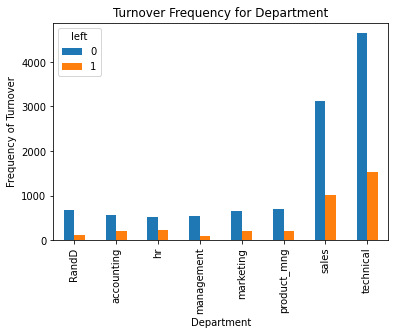

In [15]:
pd.crosstab(hr.department,hr.left).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.savefig('department_bar_chart')

From the above graph we can see that the frequency of employee turnover depends on the department they work for. Thus, department can be a good predictor of the outcome variable.

#### Salary Level vs Turnover

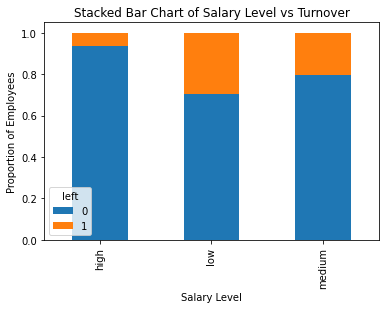

In [16]:
table=pd.crosstab(hr.salary, hr.left)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Salary Level vs Turnover')
plt.xlabel('Salary Level')
plt.ylabel('Proportion of Employees')
plt.savefig('salary_bar_chart')

From the above graph, we can say that the proportion of the employee turnover highly depends on their salary level. Hence, salary level can be a good predictor in predicting the outcome.

## Visualize Class Imbalance

In [17]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

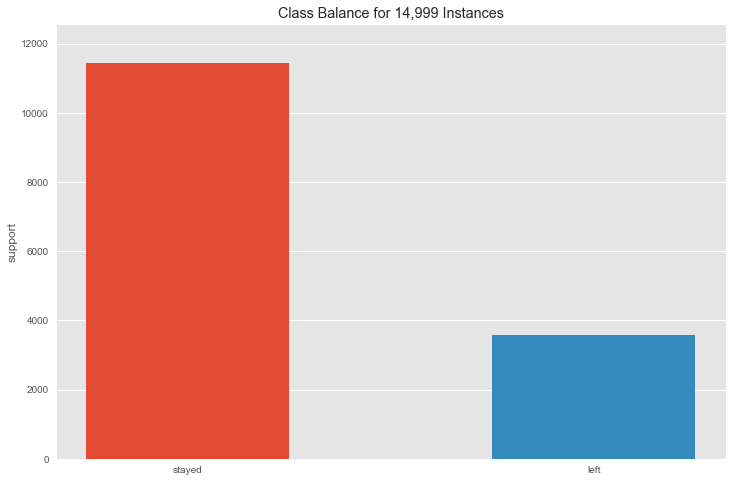

In [18]:
visualizer = ClassBalance(labels=["stayed", "left"])

visualizer.fit(hr.left)
visualizer.show();

### Creating Dummy Variables for Categorical Variables

There are two categorical variables (department, salary) in the dataset and they need to be converted to dummy variables before they can be used for modelling.

In [19]:
cat_vars=['department','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr1=hr.join(cat_list)
    hr=hr1

In [20]:
hr.drop(hr.columns[[8, 9]], axis=1, inplace=True)
hr.columns.values

array(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'left', 'promotion_last_5years', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng',
       'department_sales', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'], dtype=object)

In [21]:
hr_vars=hr.columns.values.tolist()
y=['left']
X=[i for i in hr_vars if i not in y]

In [22]:
hr[X].head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,1,0,0,1,0


## Feature Selection

In [23]:
model = LogisticRegression()
rfe = RFE(model, 10)
rfe = rfe.fit(hr[X], hr[y])
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False  True  True  True  True False  True  True False
 False False False  True  True False]
[1 1 3 9 1 1 1 1 5 1 1 6 8 7 4 1 1 2]


<strong> Recursive Feature Elimination </strong> (RFE) selected the 10 variables which are significant and which can predict employee turnover with great accuracy. These variables are marked True in the support_ array and marked with a choice “1” in the ranking_array.

## Modelling

In [24]:
cols=['satisfaction_level', 'last_evaluation', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 
      'department_RandD', 'department_hr', 'department_management', 'salary_high', 'salary_low'] 
X=hr[cols]
y=hr['left']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Logistic Regression Model

In [26]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.771


## Random Forest

In [28]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Random Forest Accuracy: 0.976


## Support Vector Machine

In [30]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [31]:
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))

Support vector machine accuracy: 0.909


## Decision Tree Classifier

In [32]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [33]:
print('Decision Tree Classifier accuracy: {:.3f}'.format(accuracy_score(y_test, DT.predict(X_test))))

Decision Tree Classifier accuracy: 0.969


<strong> Random Forest </strong> has the highest accuracy

# Cross Validation

Cross validation attempts to avoid overfitting while still producing a prediction for each observation dataset. We are using 10-fold Cross-Validation to train our Random Forest model.

In [34]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = RandomForestClassifier()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.979


The average accuracy remains very close to the Random Forest model accuracy; hence, we can conclude that the model generalizes well.<br>


## Precision and recall

#### Random Forest

In [35]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3462
           1       0.95      0.95      0.95      1038

    accuracy                           0.98      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.98      0.98      0.98      4500



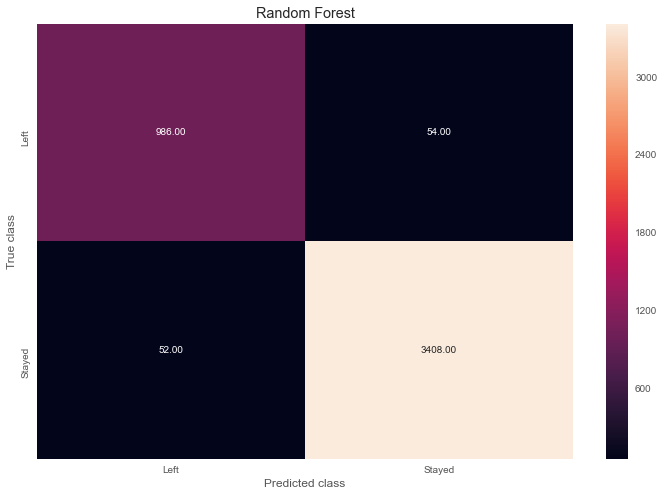

In [36]:
y_pred = rf.predict(X_test)

forest_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

#### Logistic Regression

In [37]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3462
           1       0.51      0.26      0.35      1038

    accuracy                           0.77      4500
   macro avg       0.66      0.59      0.60      4500
weighted avg       0.74      0.77      0.74      4500



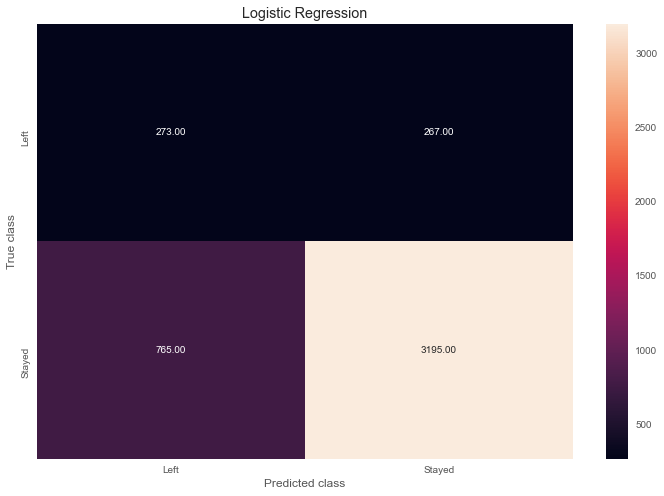

In [38]:
logreg_y_pred = logreg.predict(X_test)
logreg_cm = metrics.confusion_matrix(logreg_y_pred, y_test, [1,0])
sns.heatmap(logreg_cm, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

#### Support Vector Machine

In [39]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3462
           1       0.77      0.86      0.81      1038

    accuracy                           0.91      4500
   macro avg       0.86      0.89      0.88      4500
weighted avg       0.91      0.91      0.91      4500



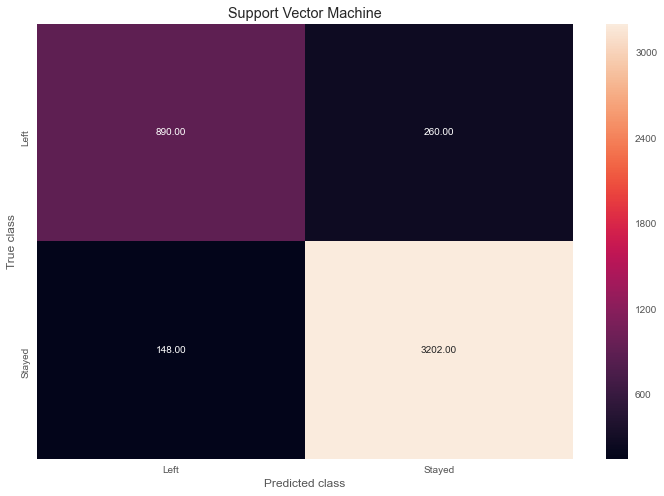

In [40]:
svc_y_pred = svc.predict(X_test)
svc_cm = metrics.confusion_matrix(svc_y_pred, y_test, [1,0])
sns.heatmap(svc_cm, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Support Vector Machine')
plt.savefig('support_vector_machine')

## The ROC Curve

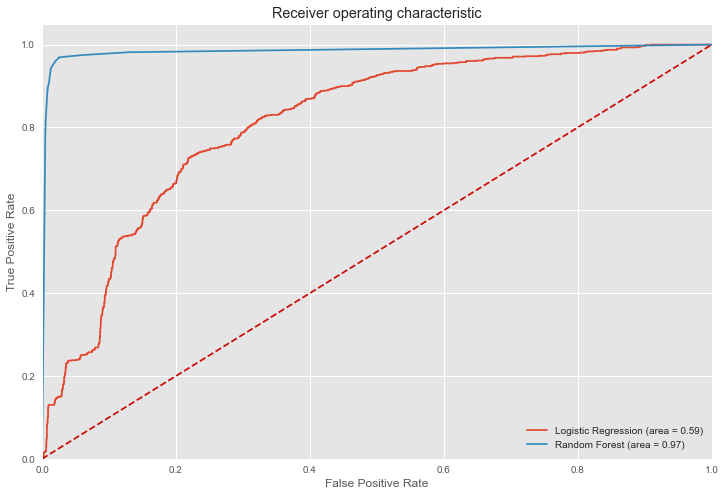

In [41]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

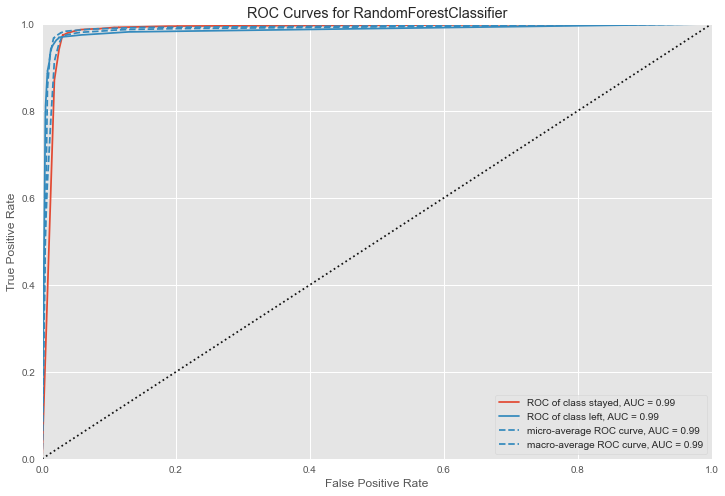

In [42]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "left"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

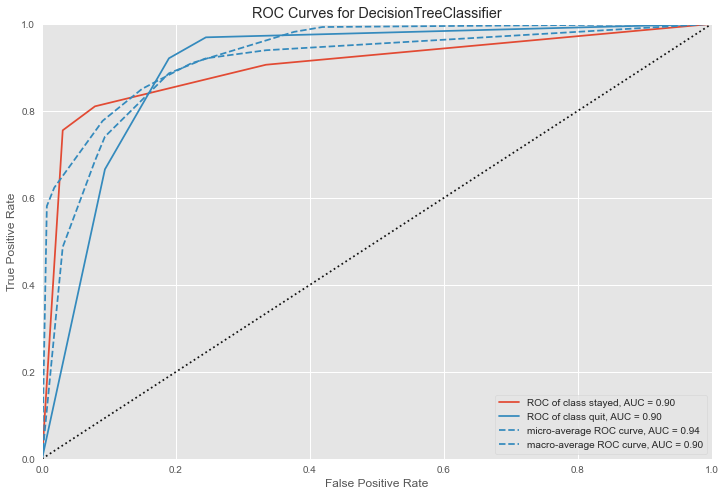

In [43]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

visualizer = ROCAUC(dt, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

Logistic Regression Accuracy: 0.777


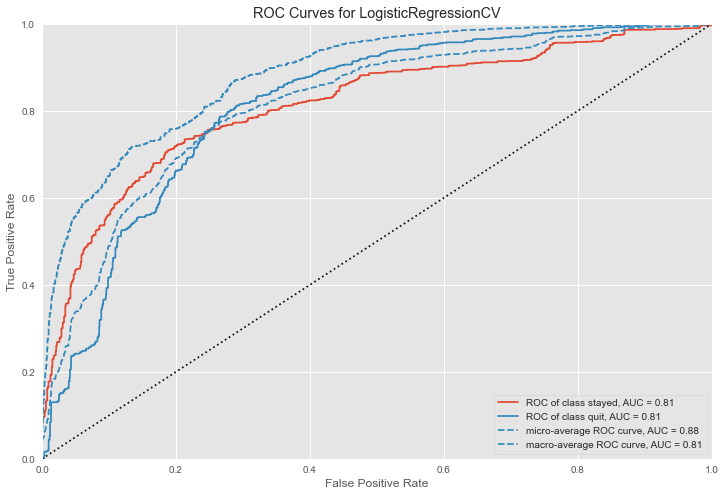

In [44]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(random_state=1, n_jobs=-1,max_iter=500,
                             cv=10)

lr = logit.fit(X_train, y_train)

print('Logistic Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, lr.predict(X_test))))

visualizer = ROCAUC(lr, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();